In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

path = kagglehub.dataset_download("fatimahirshad/faceforensics-extracted-dataset-c23")
print(path)


100%|██████████| 3.78G/3.78G [01:34<00:00, 43.0MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/fatimahirshad/faceforensics-extracted-dataset-c23/versions/3


In [ ]:
import os
print(os.listdir(path))


['FF++C32-All-frames.csv', 'FF++C32-Frames', 'CSVs']


In [ ]:
DATA_ROOT = os.path.join(path, "FF++C32-Frames")
print(os.listdir(DATA_ROOT))


['FaceShifter', 'Original', 'FaceSwap', 'NeuralTextures', 'Face2Face', 'Deepfakes']


In [ ]:
print("Original:", len(os.listdir(os.path.join(DATA_ROOT, "Original"))))
print("Deepfakes:", len(os.listdir(os.path.join(DATA_ROOT, "Deepfakes"))))


Original: 5000
Deepfakes: 5000


Using Colab cache for faster access to the 'faceforensics-extracted-dataset-c23' dataset.
['Face2Face', 'Deepfakes', 'Original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
Using device: cuda
Total: 10000
Real: 5000
Fake: 5000


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/20
Train Accuracy: 49.47%
Validation Accuracy: 53.75%

Epoch 2/20
Train Accuracy: 64.55%
Validation Accuracy: 62.06%

Epoch 3/20
Train Accuracy: 74.81%
Validation Accuracy: 69.25%

Epoch 4/20
Train Accuracy: 80.48%
Validation Accuracy: 73.50%

Epoch 5/20
Train Accuracy: 85.73%
Validation Accuracy: 76.88%

Epoch 6/20
Train Accuracy: 89.22%
Validation Accuracy: 80.00%

Epoch 7/20
Train Accuracy: 92.34%
Validation Accuracy: 82.88%

Epoch 8/20
Train Accuracy: 94.47%
Validation Accuracy: 82.88%

Epoch 9/20
Train Accuracy: 96.00%
Validation Accuracy: 84.19%

Epoch 10/20
Train Accuracy: 96.48%
Validation Accuracy: 84.88%

Epoch 11/20
Train Accuracy: 97.53%
Validation Accuracy: 83.81%

Epoch 12/20
Train Accuracy: 97.80%
Validation Accuracy: 85.19%

Epoch 13/20
Train Accuracy: 98.33%
Validation Accuracy: 85.94%

Epoch 14/20
Train Accuracy: 98.83%
Validation Accuracy: 84.75%

Epoch 15/20
Train Accuracy: 98.31%
Validation Accuracy: 84.94%

Epoch 16/20
Train Accuracy: 98.75%
Validation Ac

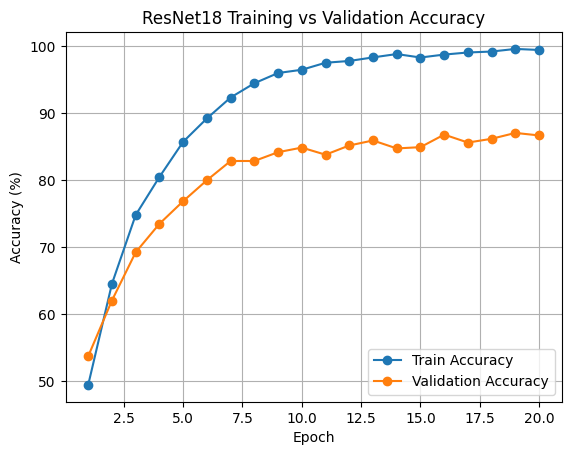

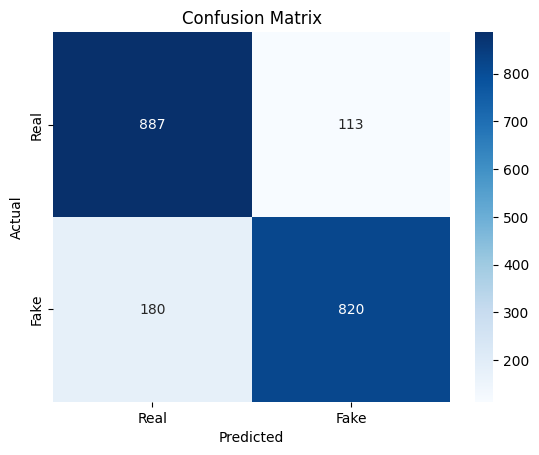

In [ ]:
# ============================================================
# FINAL DEEPFAKE DETECTION CODE (RESNET18 + LOGGING)
# ============================================================

import os
import numpy as np
import kagglehub
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# DOWNLOAD DATASET
# ============================================================

path = kagglehub.dataset_download("fatimahirshad/faceforensics-extracted-dataset-c23")
DATA_ROOT = os.path.join(path, "FF++C32-Frames")

print(os.listdir(DATA_ROOT))

# ============================================================
# CONFIG
# ============================================================

BATCH_SIZE = 32
EPOCHS = 20
LR = 0.00001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# TRANSFORMS
# ============================================================

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ============================================================
# DATASET CLASS
# ============================================================

class DeepfakeFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for f in os.listdir(os.path.join(root_dir, "Original")):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                self.image_paths.append(os.path.join(root_dir,"Original",f))
                self.labels.append(0)

        for f in os.listdir(os.path.join(root_dir, "Deepfakes")):
            if f.lower().endswith((".jpg",".png",".jpeg")):
                self.image_paths.append(os.path.join(root_dir,"Deepfakes",f))
                self.labels.append(1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# ============================================================
# LOAD DATASET
# ============================================================

dataset = DeepfakeFrameDataset(DATA_ROOT, transform)
print("Total:", len(dataset))
print("Real:", dataset.labels.count(0))
print("Fake:", dataset.labels.count(1))

# ============================================================
# SPLIT DATA
# ============================================================

indices = list(range(len(dataset)))

trainval_idx, test_idx = train_test_split(
    indices, test_size=0.20, stratify=dataset.labels, random_state=42)

train_idx, val_idx = train_test_split(
    trainval_idx, test_size=0.20,
    stratify=[dataset.labels[i] for i in trainval_idx],
    random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

# ============================================================
# MODEL
# ============================================================

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ============================================================
# TRAINING
# ============================================================

train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    model.train()
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")

# ============================================================
# TEST EVALUATION
# ============================================================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs,1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * np.mean(np.array(all_preds)==np.array(all_labels))
print("\nTEST ACCURACY:", accuracy)

cm = confusion_matrix(all_labels, all_preds)
print("\nCONFUSION MATRIX\n",cm)

print("\nCLASSIFICATION REPORT")
print(classification_report(all_labels, all_preds, target_names=["Real","Fake"]))

# ============================================================
# SAVE MODEL
# ============================================================

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/resnet18_finetuned.pth")
print("Model saved")

# ============================================================
# PLOTS (EXPERIMENTAL RESULTS)
# ============================================================

# Accuracy plot
epochs = range(1, len(train_accs)+1)

plt.figure()
plt.plot(epochs, train_accs, marker="o", label="Train Accuracy")
plt.plot(epochs, val_accs, marker="o", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNet18 Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"],
            yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
